# Saliency maps with VGG16

## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import config
import keras
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage
import tensorflow as tf
import tqdm
import warnings

from keras.applications import VGG16
from keras import activations
from utils.dataset_utils import load_images_from_list
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay

%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
print(f'sys.version: {sys.version}')
print(f'tf.version: {tf.__version__}')
print(f'keras.version: {keras.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
tf.version: 1.11.0
keras.version: 2.2.4


### 1.1 Change parameters of the experiment (and hyperparameters from ../config.py)

In [4]:
UNET_NAME = config.UNET_NAME
EXPERIMENT_NAME = config.EXPERIMENT_NAME
DATASET_PATH = f'../datasets/unseen_categories'

## 2. Load the dataset splits

In [5]:
data = {}
for split_name in ['test']:
    # load data
    in_path = f'{DATASET_PATH}/{split_name}/{split_name}_img_patches_for_sal'
    img_names = os.listdir(in_path)
    images = load_images_from_list(img_names, in_path)
    # store data
    data[split_name] = {}
    data[split_name]['img_names'] = img_names
    data[split_name]['images'] = images

print(data['test']['images'].shape, data['test']['images'].dtype,
      data['test']['images'].min(), data['test']['images'].max())
print(data['test']['img_names'][:3])

(33, 224, 224, 3) uint8 0 255
['umbrellas_503_905_1_0.png', 'cars_445_990_0_0.png', 'cars_445_990_0_1.png']


## 3. Load VGG16 model

In [6]:
# pretrained VGG16 on ImageNet
model = VGG16(weights='imagenet', include_top=True)
layer_idx = utils.find_layer_idx(model, 'predictions')

# swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

## 4. Play with vgg16 model (predict, decode_predictions)

In [7]:
img = data['test']['images'][0]
scores = model.predict(img[np.newaxis])
class_tuples = keras.applications.vgg16.decode_predictions(scores)
print(f'{scores.shape}, {scores[0, :7]} ...')
print(f'{class_tuples[:10]}')

(1, 1000), [-4.469047   2.5990543 -2.0550828 -4.456339  -5.8124375 -2.0476098
 -1.3831376] ...
[[('n03944341', 'pinwheel', 28.761278), ('n04507155', 'umbrella', 25.933271), ('n03888257', 'parachute', 19.80295), ('n02782093', 'balloon', 14.974175), ('n02883205', 'bow_tie', 13.646837)]]


In [8]:
scores = scores.squeeze()
print(scores.shape)

(1000,)


## 5. Save imagenet class names

In [9]:
class_tuples = keras.applications.vgg16.decode_predictions(np.arange(1000)[np.newaxis], top=1000)[0][::-1]
class_names = [t[1] for t in class_tuples]
print(class_names[:7])
print(class_names[-7:])

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray']
['gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet_tissue']


(224, 224) float32 0.0 0.9999314


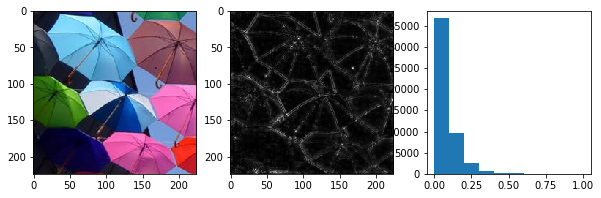

(224, 224) float32 0.0 0.9999648


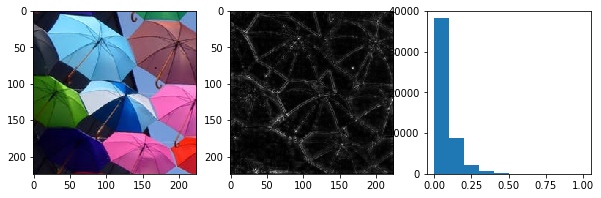

(224, 224) float32 0.0 0.9999632


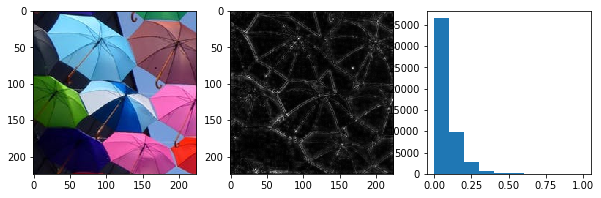

In [10]:
img = data['test']['images'][0]

for class_id in [102, 534, 987]:
    sal_map = visualize_saliency(model, layer_idx,
                                 filter_indices=class_id,
                                 seed_input=img,
                                 backprop_modifier='guided')

    print(sal_map.shape, sal_map.dtype, sal_map.min(), sal_map.max())

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.imshow(sal_map, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.hist(sal_map.flatten())
    plt.show()

## 6. Generate saliency maps for train/val/test splits

In [11]:
for split_name in data.keys():
    print(split_name)
    images = data[split_name]['images']
    img_names = data[split_name]['img_names']
    
    for img, img_name in zip(images, img_names):
        scores = model.predict(img[np.newaxis]).squeeze()
        max_score = np.max(scores)
        argmax_score = np.argmax(scores)

        for idx, modifier in enumerate([None, 'deconv', 'guided']):
            sal_map = visualize_saliency(model, layer_idx,
                                         filter_indices=argmax_score,
                                         seed_input=img,
                                         backprop_modifier=modifier)
            
            out_path = f'{DATASET_PATH}/{split_name}'\
                       f'/{split_name}_{modifier}_sal_patches_224_224'
            
            if not os.path.isdir(out_path):
                os.makedirs(out_path)
                
            filename = f'{out_path}/{img_name}'
            sal_map = (255 * sal_map).astype(np.uint8)
            
            skimage.io.imsave(filename, sal_map)

test
